In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
%cd /proj/fastsom

/proj/fastsom


In [3]:
# !pip install plotly chart-studio

In [4]:
# !pip install --upgrade fastai
# !pip uninstall -y fastai_category_encoders && pip install git+https://github.com/kireygroup/fastai-category-encoders

In [5]:
import inspect

def members(o: any):
    methods = inspect.getmembers(o, predicate=inspect.ismethod)
    objects = inspect.getmembers(o, predicate=lambda item: not inspect.isfunction(item))    
    return {
        'methods': list(dict(methods).keys()),
        'objects': {name: type(value) for name, value in objects},
    }


In [6]:
from typing import *
from fastsom import *
from fastai.tabular.all import *
from fastai_category_encoders import *

In [7]:
path = untar_data(URLs.ADULT_SAMPLE)

In [8]:
df = pd.read_csv(path/'adult.csv')

In [9]:
target = 'salary'
cont_names = [col for col in df.columns if 'float' in str(df[col].dtype) or 'int' in str(df[col].dtype) and col != target]
cat_names = [col for col in df.columns if col not in cont_names and col != target]

In [10]:
procs = [FillMissing, CategoryEncode('fasttext'), Normalize]
dls = TabularDataLoaders.from_df(df, cat_names=cat_names, cont_names=cont_names, y_names=[target], procs=procs, bs=128)

In [11]:
visualize = []
learn = SomLearner(dls, visualize=visualize, loss_func=codebook_err, lr=0.3)

## Plotly

In [18]:
data = [b for b in learn.dls.train]

In [19]:
x = torch.cat([torch.cat([b[0], b[1]], dim=-1) for b in learn.dls.train])

In [14]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
data_pca     = pca.fit_transform(x.cpu().numpy())
data_weights = pca.transform(learn.model.weights.reshape(-1, learn.model.weights.shape[-1]).cpu().numpy())

In [15]:
@delegates(go.Scatter.__init__)
def scatter(data: Union[torch.Tensor, np.ndarray], **kwargs):
    if data.shape[-1] == 1:
        return go.Scatter(x=data[...,0], **kwargs)
    elif data.shape[-1] == 2:
        return go.Scatter(x=data[...,0], y=data[...,1], **kwargs)
    elif data.shape[-1] == 3:
        return go.Scatter3d(x=data[...,0], y=data[...,1], z=data[...,2], **kwargs)
    else:
        raise ValueError('Unable to plot data with more than 3 dimensions')
        

NameError: name 'go' is not defined

In [ ]:
trace_data    = scatter(data_pca * 10, name='data', mode='markers', marker_color='#539dcc', marker_size=2)
trace_weights = scatter(data_weights * 10, name='SOM weights', mode='markers', marker_color='#e58368', marker_size=3)

data = [trace_weights, trace_data]

layout = go.Layout(title="SOM Visualization", automargin=True)

fig = go.Figure(data=data, layout=layout)

In [ ]:
fig.show()

## Training

In [12]:
%matplotlib notebook
learn.fit(5)

epoch,train_loss,valid_loss,time
0,0.162192,0.164369,00:04
1,0.154755,0.146030,00:04
2,0.159158,0.159728,00:04
3,0.161233,0.160425,00:04
4,0.155708,0.160874,00:04


## Visualization

In [13]:
interp = SomInterpretation.from_learner(learn)

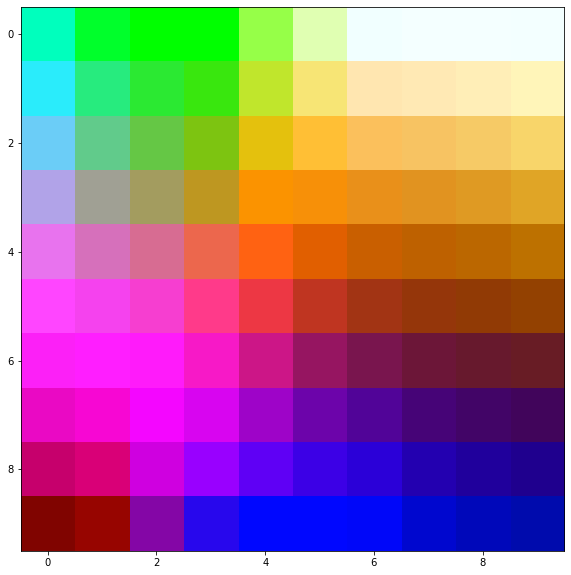

In [14]:
%matplotlib inline
interp.show_weights()

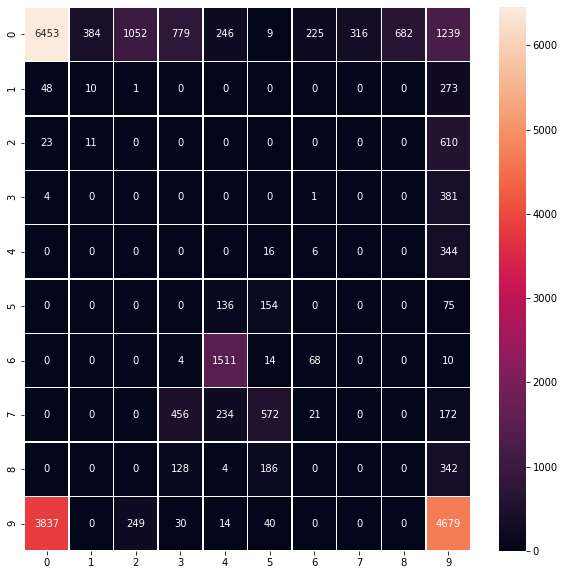

In [15]:
%matplotlib inline
interp.show_hitmap()

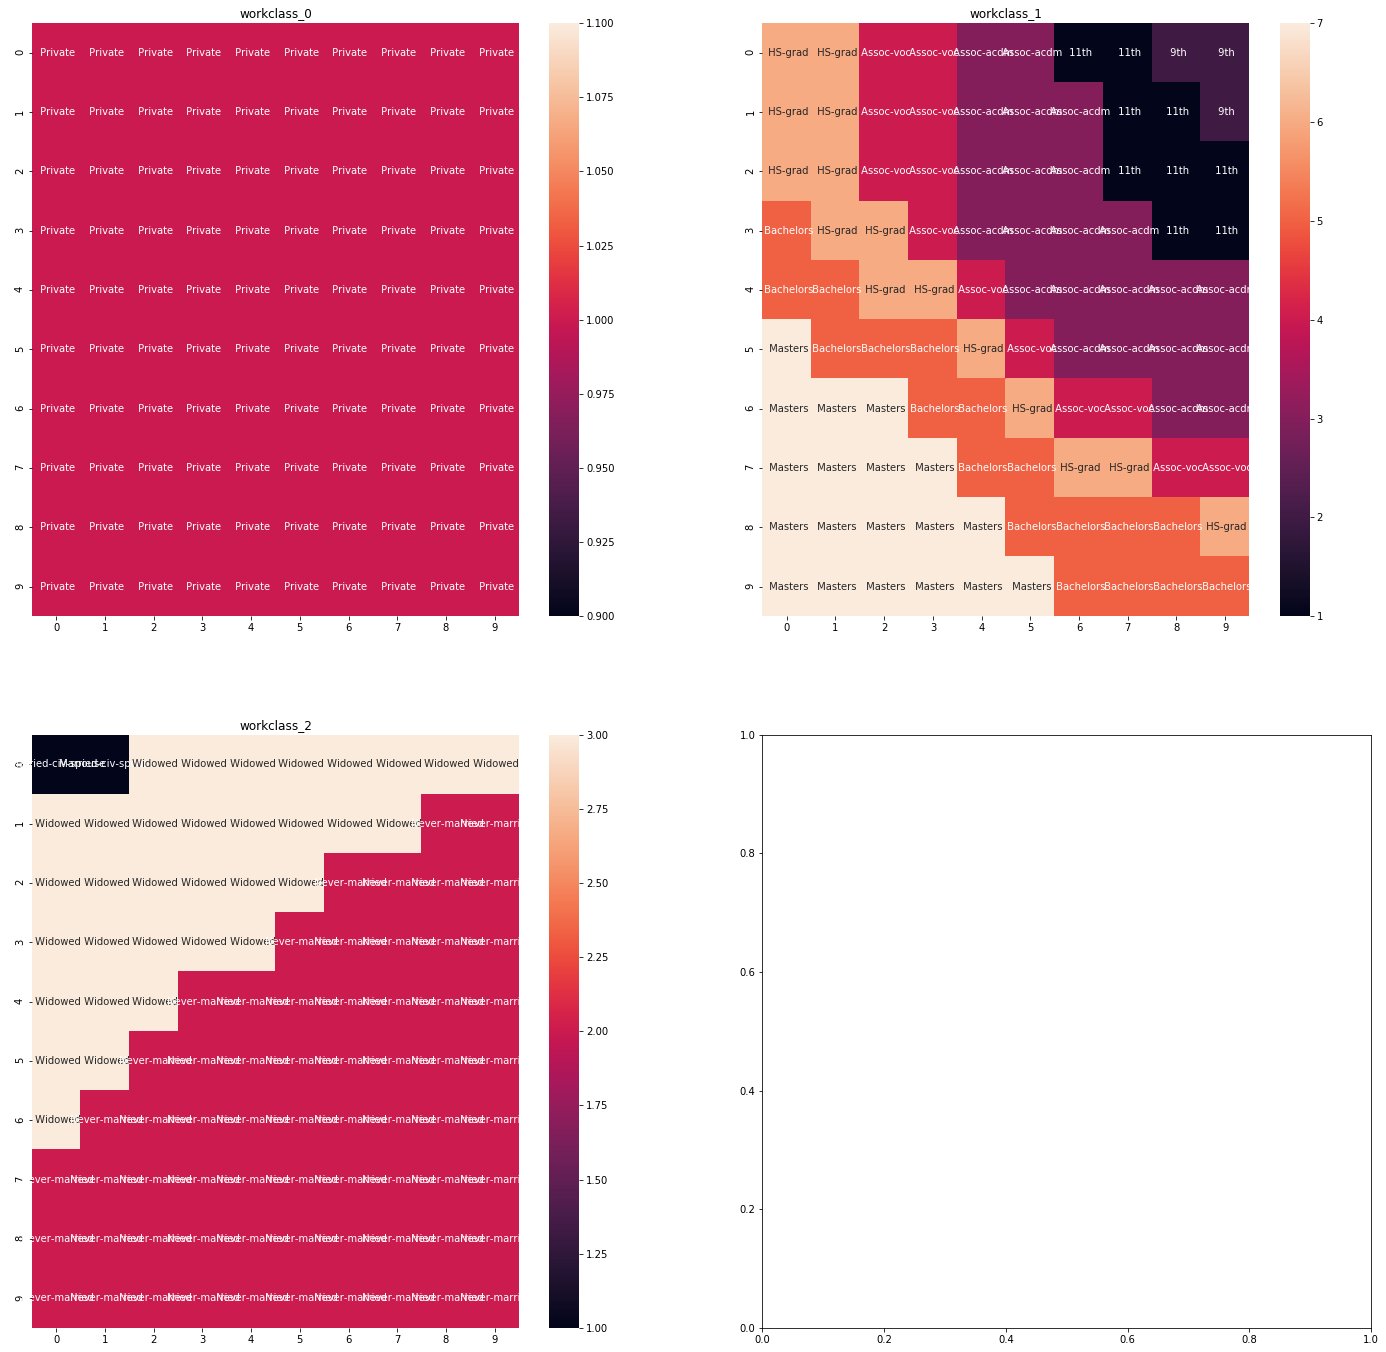

In [16]:
%matplotlib inline
interp.show_feature_heatmaps(feature_indices=[0, 1, 2])

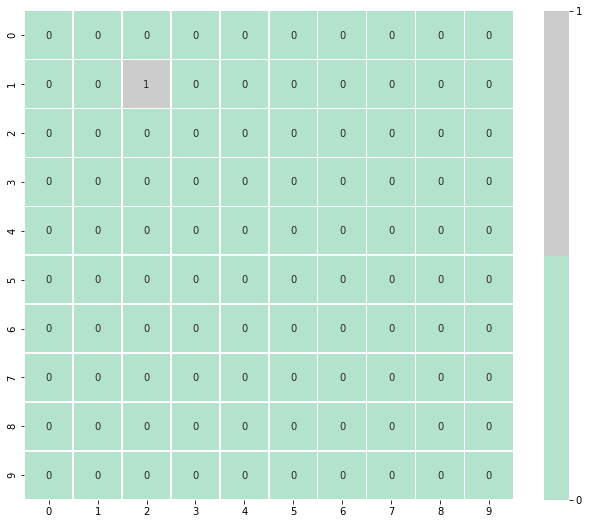

In [17]:
%matplotlib inline
interp.show_preds()

## Exporting

In [20]:
df_exp = learn.codebook_to_df(recategorize=True, denorm=True)
df_exp.head()

,workclass,education,marital-status,occupation,relationship,race,sex,native-country,education-num_na,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,som_row,som_col
0,Private,HS-grad,Married-civ-spouse,Prof-specialty,Husband,White,Male,Ireland,False,38.024747,190503.274351,10.192129,1161.452450,100.099038,40.168414,0,0
1,Private,HS-grad,Married-civ-spouse,Prof-specialty,Husband,White,Male,Ireland,False,38.023368,190176.495294,10.187087,1159.993802,99.214049,40.135244,0,1
2,Private,Assoc-voc,Widowed,Prof-specialty,Husband,White,Male,Ireland,False,38.031522,189673.984781,10.177950,1158.745946,97.823287,40.110488,0,2
3,Private,Assoc-voc,Widowed,Prof-specialty,Unmarried,White,Male,Ireland,False,38.063599,188972.317484,10.165763,1160.860358,96.436717,40.088544,0,3
4,Private,Assoc-acdm,Widowed,Prof-specialty,Unmarried,White,Male,Ireland,False,38.133987,188085.627957,10.151079,1165.596433,95.554665,40.064033,0,4


In [21]:
learn.export('example_som.pkl')